#### ver3 수정내용
- 컬럼 추가한 "부채비율" 값은 작을수록 높은 점수 부여 (def assign_grade_reverse)
- 산업별 점수화 한것 min max 스케일링

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
df2 = pd.read_excel('업종명추가.xlsx')
df2.drop(columns=['Unnamed: 0','[제조]자기자본배율(IFRS연결)','[제조]당좌비율(IFRS연결)'], inplace=True)

In [4]:
new_column_names = {'[제조]매출액증가율(IFRS연결)':'매출액증가율', '[제조]순이익증가율(IFRS연결)':'순이익증가율', '[제조]총자본증가율(IFRS연결)':'총자본증가율',
                    '[제조]자기자본순이익률(IFRS연결)':'자기자본순이익률', '[제조]총자본순이익률(IFRS연결)':'총자본순이익률', '[제조]매출액순이익률(IFRS연결)':'매출액순이익률',
                    '[제조]부채비율(IFRS연결)':'부채비율', '[제조]유동비율(IFRS연결)':'유동비율', '[제조]이자보상배율(이자비용)(IFRS연결)':'이자보상배율',   
                    '[제조]총자본회전률(IFRS연결)':'총자본회전률','[제조]재고자산회전률(IFRS연결)':'재고자산회전률', '[제조]매출채권회전률(IFRS연결)':'매출채권회전률'}


df2= df2.rename(columns=new_column_names)
df2.head(2)

,회사명,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,총자본회전률,재고자산회전률,매출채권회전률,업종분류,new업종명
0,AJ네트웍스,1.066667,-29.426667,-5.760000,8.313333,1.876667,2.623333,344.863333,47.17,1.296667,0.716667,38.160000,11.69,9,종합서비스업
1,CMG제약,12.016667,426.463333,3.546667,0.546667,0.506667,1.473333,10.333333,866.74,118.376667,0.360000,5.013333,3.66,3,화학물질 및 의약품 제조업


In [5]:
dfs_by_category = [group for _, group in df2.groupby('업종분류')] # 업종별로 분리
selected_columns = ['매출액증가율','순이익증가율','총자본증가율','자기자본순이익률','총자본순이익률','매출액순이익률','부채비율','유동비율','이자보상배율','총자본회전률','재고자산회전률','매출채권회전률']

In [26]:
# 업종별 dfs_by_category 정보와 기업 수
# dfs_by_category[0]  : 식품 제조업, 기업수 69개

for i in range(9):  
    print(f"dfs_by_category[{i}]  :  {dfs_by_category[i].iloc[:, 14].unique(), len(dfs_by_category[i])}")


dfs_by_category[0]  :  (array(['식품 제조업'], dtype=object), 69)
dfs_by_category[1]  :  (array(['섬유 및 목재 제조업'], dtype=object), 81)
dfs_by_category[2]  :  (array(['화학물질 및 의약품 제조업'], dtype=object), 297)
dfs_by_category[3]  :  (array(['금속 및 비금속 제조업'], dtype=object), 927)
dfs_by_category[4]  :  (array(['에너지 및 원료 공급업'], dtype=object), 13)
dfs_by_category[5]  :  (array(['건설업'], dtype=object), 50)
dfs_by_category[6]  :  (array(['도소매업'], dtype=object), 145)
dfs_by_category[7]  :  (array(['운송업'], dtype=object), 24)
dfs_by_category[8]  :  (array(['종합서비스업'], dtype=object), 442)


In [6]:
# 등급을 할당하는 함수
def assign_grade(value, thresholds):
    for i, threshold in enumerate(thresholds):
        if value <= threshold:
            return i
    return len(thresholds)

# 등급을 할당하는 함수 : 점수가 낮을 경우 높은 점수를 받음
# 부채비율
def assign_grade_reverse(value, thresholds):
    for i, threshold in enumerate(thresholds):
        if value <= threshold: 
            return len(thresholds) - i  
    return 0  # 모든 임계값보다 큰 경우에는 가장 낮은 등급을 부여

# 각 업종별로 데이터프레임을 순회하면서 등급을 할당하고, 각 컬럼별로 점수를 계산하여 새로운 칼럼을 추가
for category, df_category in enumerate(dfs_by_category):
    # 각 컬럼별로 중위값과 등급을 계산
    median_grade_by_column = {}
    for column in selected_columns:
        column_data = df_category[column]
        median = np.median(column_data)
        thresholds = np.percentile(column_data, [20, 40, 60, 80])
        median_grade_by_column[column] = (median, thresholds)
    
    # 각 행에 대해 등급을 할당하고 점수를 계산하여 새로운 칼럼에 추가
    for idx, row in df_category.iterrows():
        total_score = 0
        
    # median_grade_by_column 딕셔너리에 있는 각 열의 중앙값(median)과 임계값(thresholds)에 대해 반복
        for column, (median, thresholds) in median_grade_by_column.items():
            value = row[column]
            if column == '부채비율':
                grade = assign_grade_reverse(value, thresholds)
            else : 
                grade = assign_grade(value, thresholds)
            total_score += grade
            new_column_name = f"{column}_등급"
            df_category.at[idx, new_column_name] = grade
        # 점수를 계산하여 새로운 칼럼에 추가
        score_column_name = "총점수"
        df_category.at[idx, score_column_name] = total_score

In [27]:
dfs_by_category[0].sort_values('부채비율')  # 식품제조업

,회사명,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
1029,에이치엘사이언스,-21.706667,-39.293333,5.313333,12.426667,11.063333,10.073333,8.593333,825.750000,7252.180000,...,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0,35.0
546,비피도,4.443333,-21.866667,4.463333,3.740000,3.396667,14.403333,9.200000,847.230000,-35.133333,...,1.0,2.0,4.0,4.0,4.0,0.0,0.0,0.0,1.0,19.0
63,국순당,-3.516667,5.070000,0.366667,5.423333,4.723333,20.723333,9.470000,687.336667,448.160000,...,2.0,3.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,25.0
1803,풍국주정공업,5.920000,-15.490000,1.053333,4.420000,4.190000,6.093333,17.180000,260.306667,22.440000,...,2.0,3.0,3.0,4.0,4.0,4.0,1.0,4.0,0.0,28.0
116,남양유업,-2.100000,0.000000,-5.116667,-7.733333,-6.606667,-6.643333,17.856667,441.616667,-116.733333,...,0.0,0.0,0.0,4.0,4.0,0.0,2.0,0.0,1.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,한성기업,3.066667,0.000000,1.146667,-2.786667,-0.693333,-0.550000,328.593333,92.730000,0.550000,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,0.0,10.0
1532,체리부로,10.386667,0.000000,-0.060000,-34.950000,-8.376667,-7.006667,378.600000,52.053333,-0.516667,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,14.0
7,MH에탄올,11.113333,-9.686667,-0.296667,9.573333,1.806667,7.760000,420.383333,23.650000,1.693333,...,3.0,1.0,4.0,0.0,0.0,1.0,0.0,3.0,2.0,18.0
1536,카나리아바이오,12.300000,-32.020000,46.043333,-269.686667,-64.026667,-64.870000,422.490000,170.073333,2.156667,...,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,0.0,15.0


In [28]:
dfs_by_category[0].describe()

,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,총자본회전률,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.000000
mean,8.360821,17.515314,9.832947,-0.658551,1.522995,1.416908,118.599082,202.391884,142.938841,1.021401,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,24.000000
std,8.808594,93.500447,12.285583,34.797318,9.643123,12.416784,103.323461,188.710506,879.155634,0.434447,...,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,9.116888
min,-21.706667,-113.536667,-5.116667,-269.686667,-64.026667,-64.870000,8.593333,23.650000,-116.733333,0.223333,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.000000
25%,4.710000,-14.696667,1.146667,1.336667,0.930000,0.830000,46.986667,98.013333,2.043333,0.720000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,17.000000
50%,7.686667,0.000000,6.520000,5.423333,2.610000,3.073333,86.283333,138.890000,5.113333,0.993333,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,24.000000
75%,13.453333,17.216667,13.900000,9.726667,4.723333,5.916667,153.316667,207.116667,14.610000,1.283333,...,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,30.000000
max,24.893333,675.626667,68.446667,19.676667,13.660000,20.723333,461.546667,847.230000,7252.180000,2.143333,...,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,45.000000


In [29]:
dfs_by_category[0].sort_values('총점수', ascending=False)  # 식품제조업

,회사명,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
163,뉴트리,20.786667,9.270000,25.270000,19.676667,13.570000,6.880000,49.083333,336.636667,46.876667,...,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,45.0
1035,에이치피오,11.526667,-10.723333,33.836667,17.293333,13.660000,10.440000,18.240000,409.306667,299.746667,...,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,43.0
571,삼양식품,19.963333,12.766667,25.490000,18.586667,10.486667,9.376667,84.626667,144.080000,101.726667,...,4.0,4.0,4.0,2.0,2.0,4.0,3.0,4.0,3.0,41.0
1145,오뚜기,10.580000,47.886667,19.026667,11.120000,6.400000,5.916667,71.636667,134.980000,17.023333,...,4.0,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,39.0
148,노바렉스,22.070000,17.216667,21.340000,19.130000,10.766667,9.246667,72.303333,158.860000,66.143333,...,4.0,4.0,4.0,3.0,3.0,4.0,3.0,1.0,1.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,무학,-1.583333,-14.696667,-0.823333,-1.093333,-0.840000,-3.920000,23.286667,80.580000,2.853333,...,0.0,0.0,0.0,4.0,0.0,1.0,0.0,3.0,1.0,10.0
1923,한성기업,3.066667,0.000000,1.146667,-2.786667,-0.693333,-0.550000,328.593333,92.730000,0.550000,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,0.0,10.0
501,보해양조,6.150000,0.000000,-3.970000,-0.783333,-0.463333,-0.670000,83.363333,115.313333,0.563333,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,7.0
631,서울식품공업,1.750000,0.000000,-2.293333,-9.373333,-3.410000,-4.486667,163.843333,66.746667,-0.623333,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,7.0


In [31]:
dfs_by_category[0].keys()

Index(['회사명', '매출액증가율', '순이익증가율', '총자본증가율', '자기자본순이익률', '총자본순이익률', '매출액순이익률',
       '부채비율', '유동비율', '이자보상배율', '총자본회전률', '재고자산회전률', '매출채권회전률', '업종분류',
       'new업종명', '매출액증가율_등급', '순이익증가율_등급', '총자본증가율_등급', '자기자본순이익률_등급',
       '총자본순이익률_등급', '매출액순이익률_등급', '부채비율_등급', '유동비율_등급', '이자보상배율_등급',
       '총자본회전률_등급', '재고자산회전률_등급', '매출채권회전률_등급', '총점수'],
      dtype='object')

#### 산업별 점수매긴것 minmax 스케일링

In [34]:
import copy
from sklearn.preprocessing import MinMaxScaler

# dfs_by_category를 deepcopy하여 새로운 변수에 저장
dfs_minmax = copy.deepcopy(dfs_by_category)

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 각 업종별 데이터프레임에 대해 스케일링 수행
for i, df in enumerate(dfs_minmax):
    # 스케일링할 열 선택
    columns_to_scale = ['매출액증가율_등급', '순이익증가율_등급', '총자본증가율_등급', '자기자본순이익률_등급',
                        '총자본순이익률_등급', '매출액순이익률_등급', '부채비율_등급', '유동비율_등급', 
                        '이자보상배율_등급', '총자본회전률_등급', '재고자산회전률_등급', '매출채권회전률_등급', '총점수']
    
    # 각 열에 대해 스케일링 수행
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# 결과 확인
for i, df in enumerate(dfs_minmax):
    print(f"dfs_minmax[{i}]의 스케일링 결과:")
    print(df[columns_to_scale].head())  # 스케일링된 결과 출력


dfs_minmax[0]의 스케일링 결과:
     매출액증가율_등급  순이익증가율_등급  총자본증가율_등급  자기자본순이익률_등급  총자본순이익률_등급  매출액순이익률_등급  \
7         0.75       0.25       0.00         0.75        0.25        1.00   
40        0.75       0.00       0.75         0.50        0.25        0.25   
63        0.00       0.75       0.00         0.50        0.75        1.00   
116       0.00       0.50       0.00         0.00        0.00        0.00   
126       0.75       0.75       1.00         0.25        0.25        0.25   

     부채비율_등급  유동비율_등급  이자보상배율_등급  총자본회전률_등급  재고자산회전률_등급  매출채권회전률_등급       총점수  
7       0.00     0.00       0.25        0.0        0.75        0.50  0.307692  
40      0.25     0.25       0.25        0.5        0.25        0.00  0.256410  
63      1.00     1.00       1.00        0.0        0.00        0.25  0.487179  
116     1.00     1.00       0.00        0.5        0.00        0.25  0.179487  
126     1.00     1.00       0.75        0.0        0.00        0.25  0.487179  
dfs_minmax[1]의 스케일링 결과:
    매출액증가

In [37]:
dfs_minmax[0] 

,회사명,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
7,MH에탄올,11.113333,-9.686667,-0.296667,9.573333,1.806667,7.760000,420.383333,23.650000,1.693333,...,0.75,0.25,1.00,0.00,0.00,0.25,0.00,0.75,0.50,0.307692
40,고려산업,13.813333,-21.953333,10.063333,3.960000,1.783333,1.940000,131.443333,88.646667,2.576667,...,0.50,0.25,0.25,0.25,0.25,0.25,0.50,0.25,0.00,0.256410
63,국순당,-3.516667,5.070000,0.366667,5.423333,4.723333,20.723333,9.470000,687.336667,448.160000,...,0.50,0.75,1.00,1.00,1.00,1.00,0.00,0.00,0.25,0.487179
116,남양유업,-2.100000,0.000000,-5.116667,-7.733333,-6.606667,-6.643333,17.856667,441.616667,-116.733333,...,0.00,0.00,0.00,1.00,1.00,0.00,0.50,0.00,0.25,0.179487
126,네오크레마,13.453333,22.613333,19.736667,1.336667,1.183333,1.233333,36.256667,482.830000,8.903333,...,0.25,0.25,0.25,1.00,1.00,0.75,0.00,0.00,0.25,0.487179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,한성기업,3.066667,0.000000,1.146667,-2.786667,-0.693333,-0.550000,328.593333,92.730000,0.550000,...,0.00,0.00,0.00,0.00,0.25,0.00,0.75,0.75,0.00,0.102564
1947,한일사료,6.200000,78.393333,2.816667,-2.883333,-0.620000,-0.226667,179.513333,103.336667,2.220000,...,0.00,0.00,0.00,0.00,0.25,0.25,1.00,0.25,1.00,0.282051
1963,한탑,3.830000,0.000000,3.563333,-21.156667,-7.816667,-13.103333,160.763333,53.596667,-1.500000,...,0.00,0.00,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.000000
1969,해태제과식품,-4.543333,0.000000,-2.316667,3.260000,1.203333,1.483333,153.316667,52.083333,4.033333,...,0.25,0.25,0.25,0.25,0.00,0.50,0.25,1.00,0.25,0.205128


In [38]:
dfs_minmax[0].describe()

,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,총자본회전률,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,8.360821,17.515314,9.832947,-0.658551,1.522995,1.416908,118.599082,202.391884,142.938841,1.021401,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.461538
std,8.808594,93.500447,12.285583,34.797318,9.643123,12.416784,103.323461,188.710506,879.155634,0.434447,...,0.358715,0.358715,0.358715,0.358715,0.358715,0.358715,0.358715,0.358715,0.358715,0.233766
min,-21.706667,-113.536667,-5.116667,-269.686667,-64.026667,-64.870000,8.593333,23.650000,-116.733333,0.223333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.710000,-14.696667,1.146667,1.336667,0.930000,0.830000,46.986667,98.013333,2.043333,0.720000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.282051
50%,7.686667,0.000000,6.520000,5.423333,2.610000,3.073333,86.283333,138.890000,5.113333,0.993333,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.461538
75%,13.453333,17.216667,13.900000,9.726667,4.723333,5.916667,153.316667,207.116667,14.610000,1.283333,...,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.615385
max,24.893333,675.626667,68.446667,19.676667,13.660000,20.723333,461.546667,847.230000,7252.180000,2.143333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
dfs_minmax[0].sort_values('총점수', ascending=False)

,회사명,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
163,뉴트리,20.786667,9.270000,25.270000,19.676667,13.570000,6.880000,49.083333,336.636667,46.876667,...,1.00,1.0,0.75,0.75,1.00,1.00,1.00,1.00,1.00,1.000000
1035,에이치피오,11.526667,-10.723333,33.836667,17.293333,13.660000,10.440000,18.240000,409.306667,299.746667,...,1.00,1.0,1.00,1.00,1.00,1.00,0.75,1.00,1.00,0.948718
571,삼양식품,19.963333,12.766667,25.490000,18.586667,10.486667,9.376667,84.626667,144.080000,101.726667,...,1.00,1.0,1.00,0.50,0.50,1.00,0.75,1.00,0.75,0.897436
1145,오뚜기,10.580000,47.886667,19.026667,11.120000,6.400000,5.916667,71.636667,134.980000,17.023333,...,1.00,1.0,0.75,0.75,0.50,0.75,0.75,0.75,0.75,0.846154
148,노바렉스,22.070000,17.216667,21.340000,19.130000,10.766667,9.246667,72.303333,158.860000,66.143333,...,1.00,1.0,1.00,0.75,0.75,1.00,0.75,0.25,0.25,0.820513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,무학,-1.583333,-14.696667,-0.823333,-1.093333,-0.840000,-3.920000,23.286667,80.580000,2.853333,...,0.00,0.0,0.00,1.00,0.00,0.25,0.00,0.75,0.25,0.102564
1923,한성기업,3.066667,0.000000,1.146667,-2.786667,-0.693333,-0.550000,328.593333,92.730000,0.550000,...,0.00,0.0,0.00,0.00,0.25,0.00,0.75,0.75,0.00,0.102564
501,보해양조,6.150000,0.000000,-3.970000,-0.783333,-0.463333,-0.670000,83.363333,115.313333,0.563333,...,0.25,0.0,0.00,0.50,0.25,0.00,0.00,0.00,0.00,0.025641
631,서울식품공업,1.750000,0.000000,-2.293333,-9.373333,-3.410000,-4.486667,163.843333,66.746667,-0.623333,...,0.00,0.0,0.00,0.25,0.00,0.00,0.25,0.75,0.00,0.025641


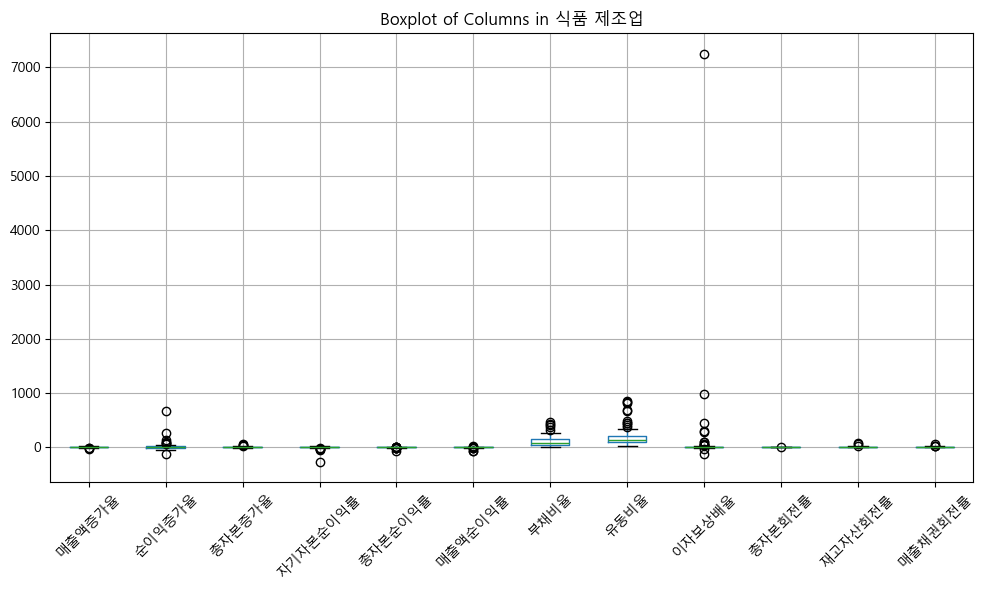

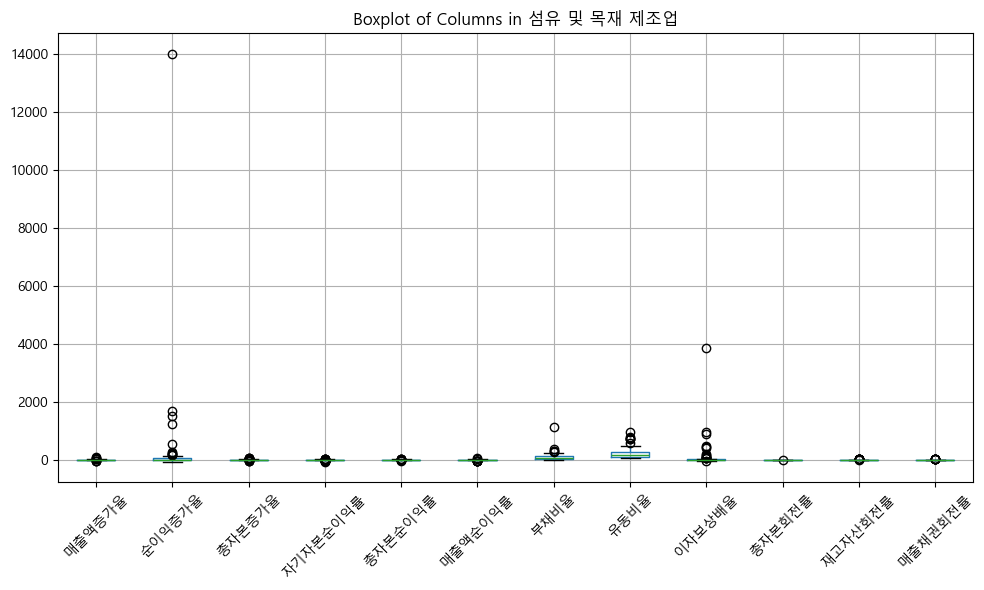

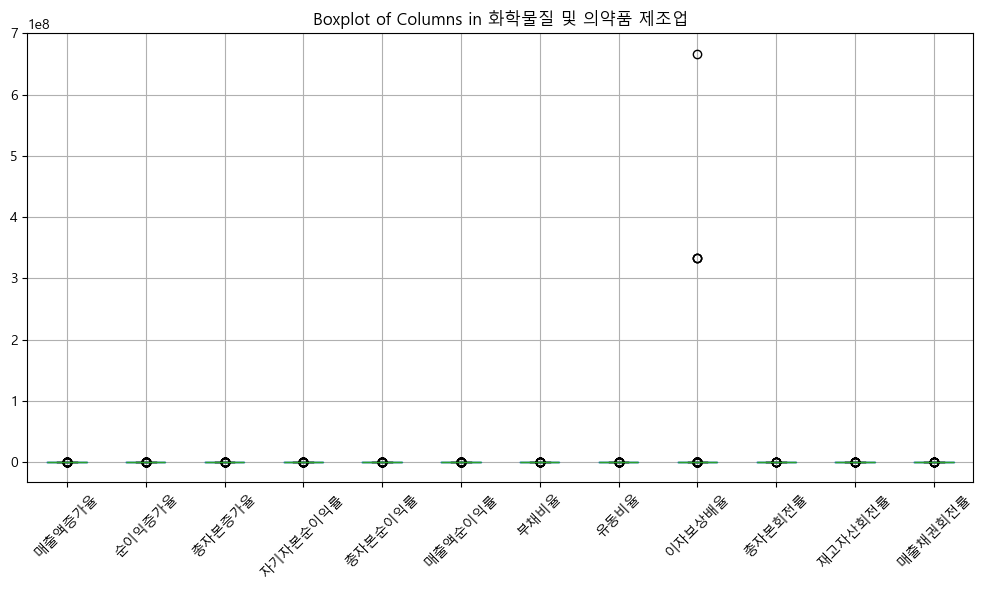

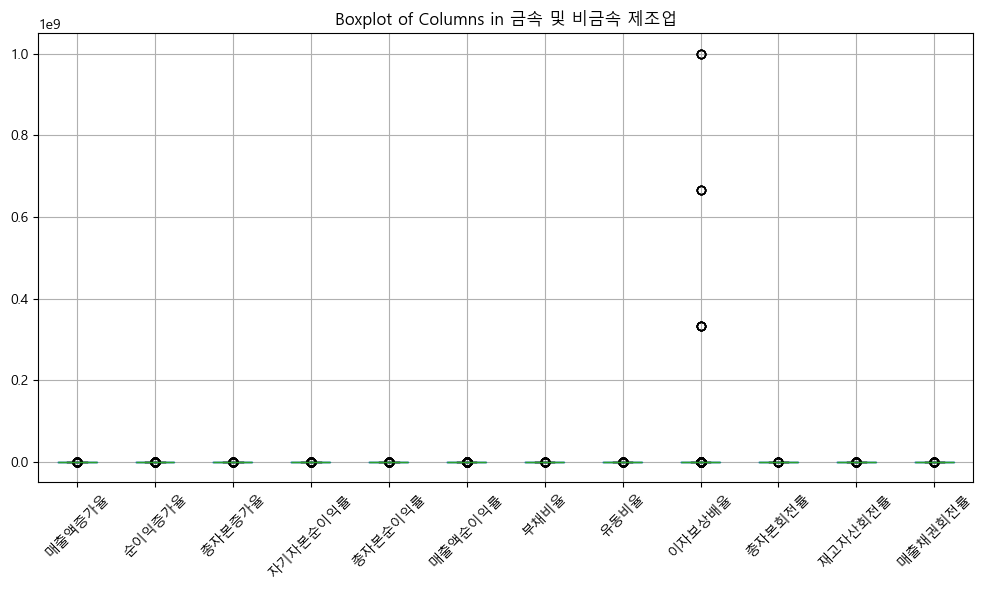

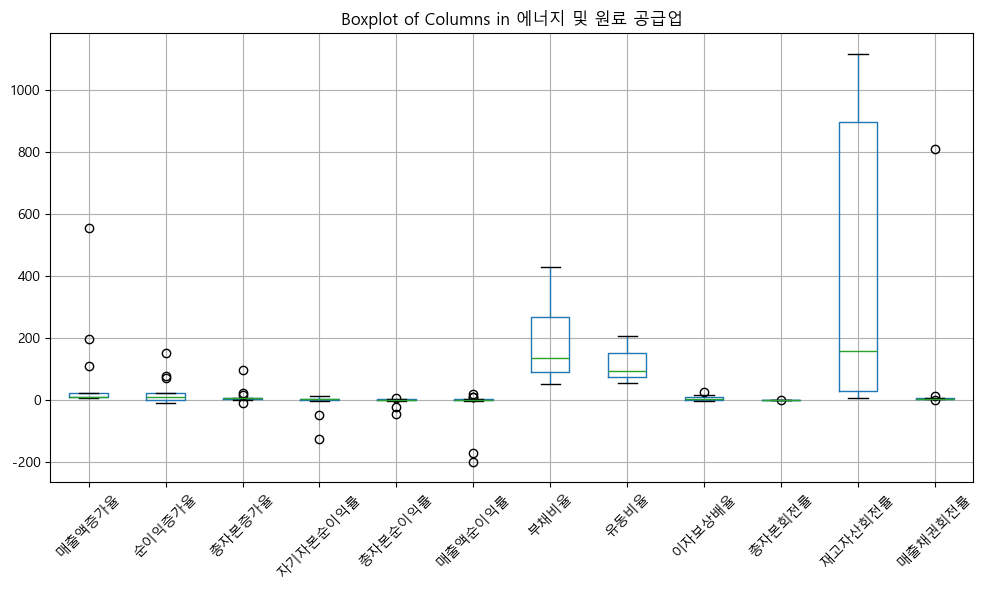

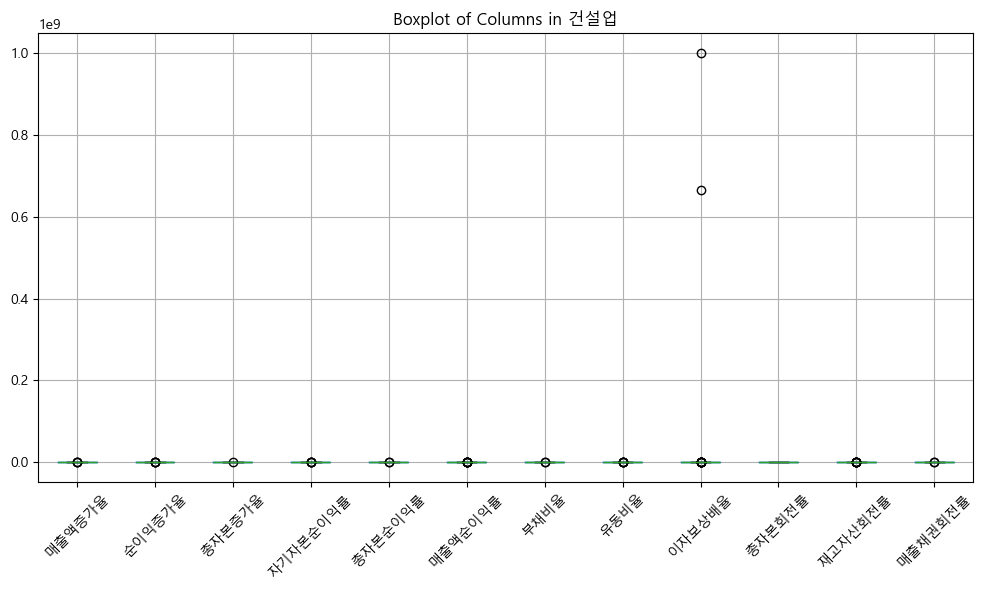

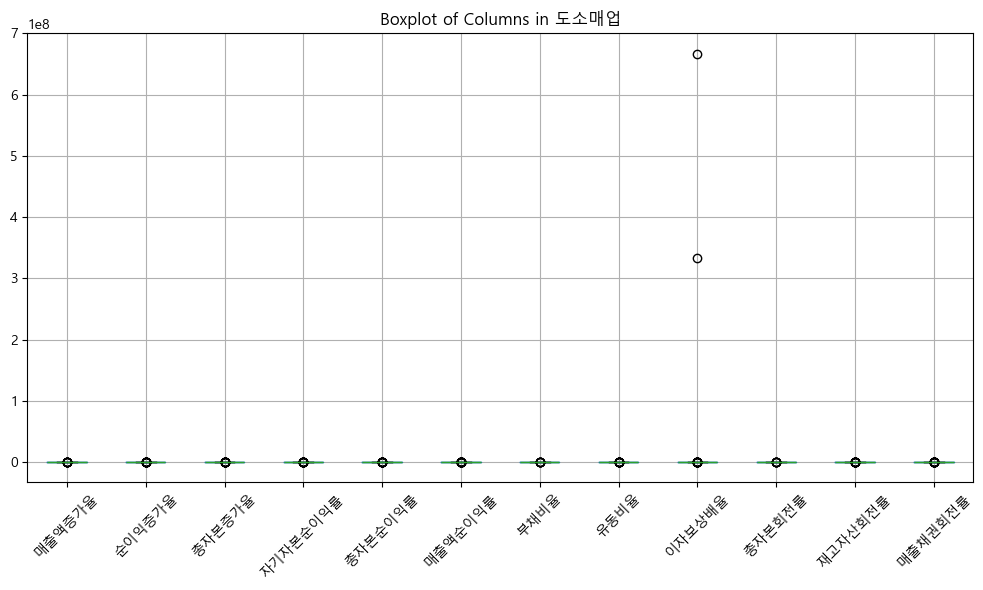

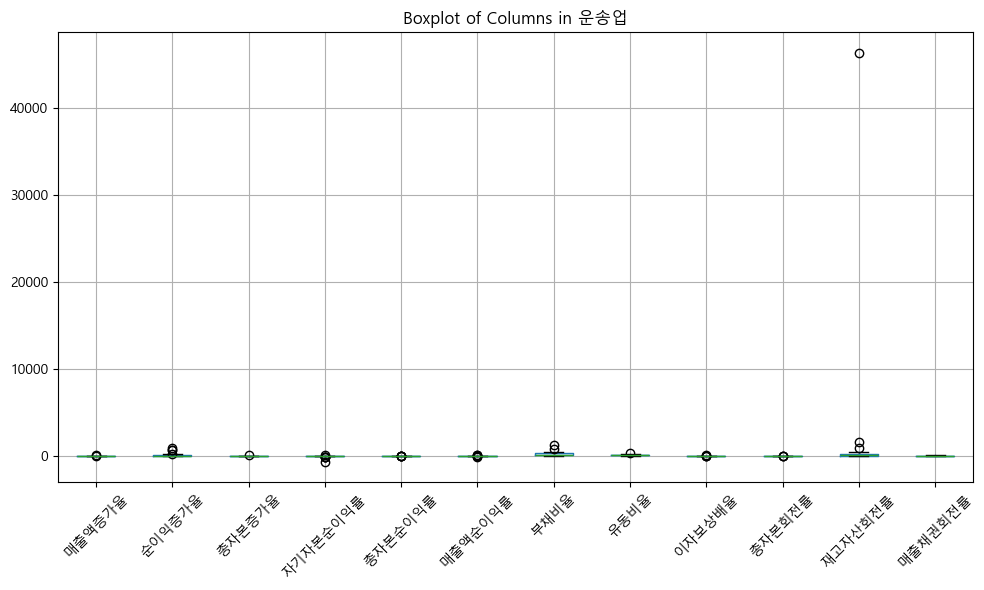

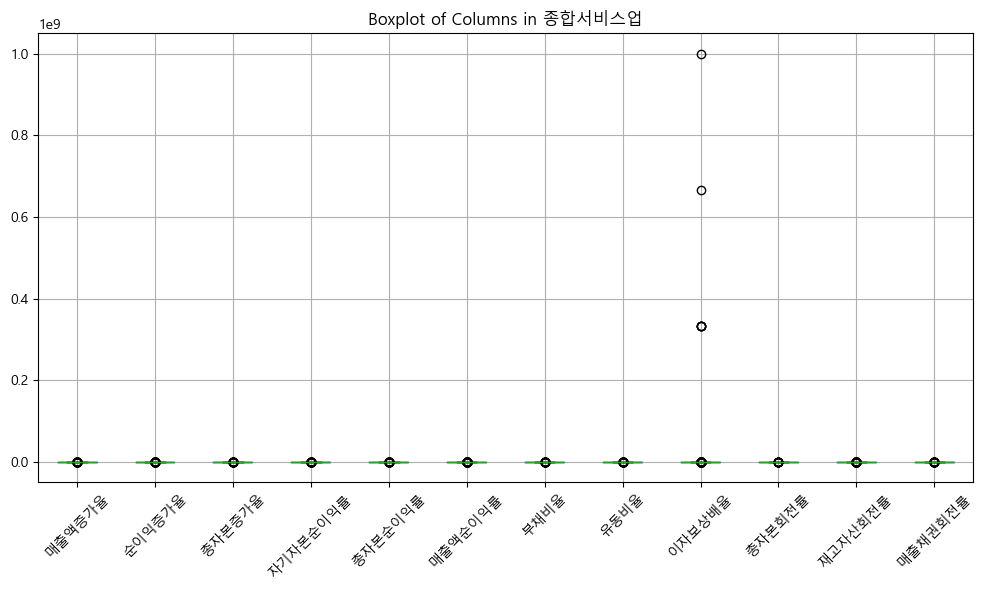

In [7]:
for i, df_category in enumerate(dfs_by_category[:9]):
    plt.figure(figsize=(10, 6))
    df_category[selected_columns].boxplot()
    plt.title(f'Boxplot of Columns in {df_category.iloc[0]["new업종명"]}', fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.tight_layout()
    plt.show()

In [8]:
dfs_by_category[i].keys()

Index(['회사명', '매출액증가율', '순이익증가율', '총자본증가율', '자기자본순이익률', '총자본순이익률', '매출액순이익률',
       '부채비율', '유동비율', '이자보상배율', '총자본회전률', '재고자산회전률', '매출채권회전률', '업종분류',
       'new업종명', '매출액증가율_등급', '순이익증가율_등급', '총자본증가율_등급', '자기자본순이익률_등급',
       '총자본순이익률_등급', '매출액순이익률_등급', '부채비율_등급', '유동비율_등급', '이자보상배율_등급',
       '총자본회전률_등급', '재고자산회전률_등급', '매출채권회전률_등급', '총점수'],
      dtype='object')

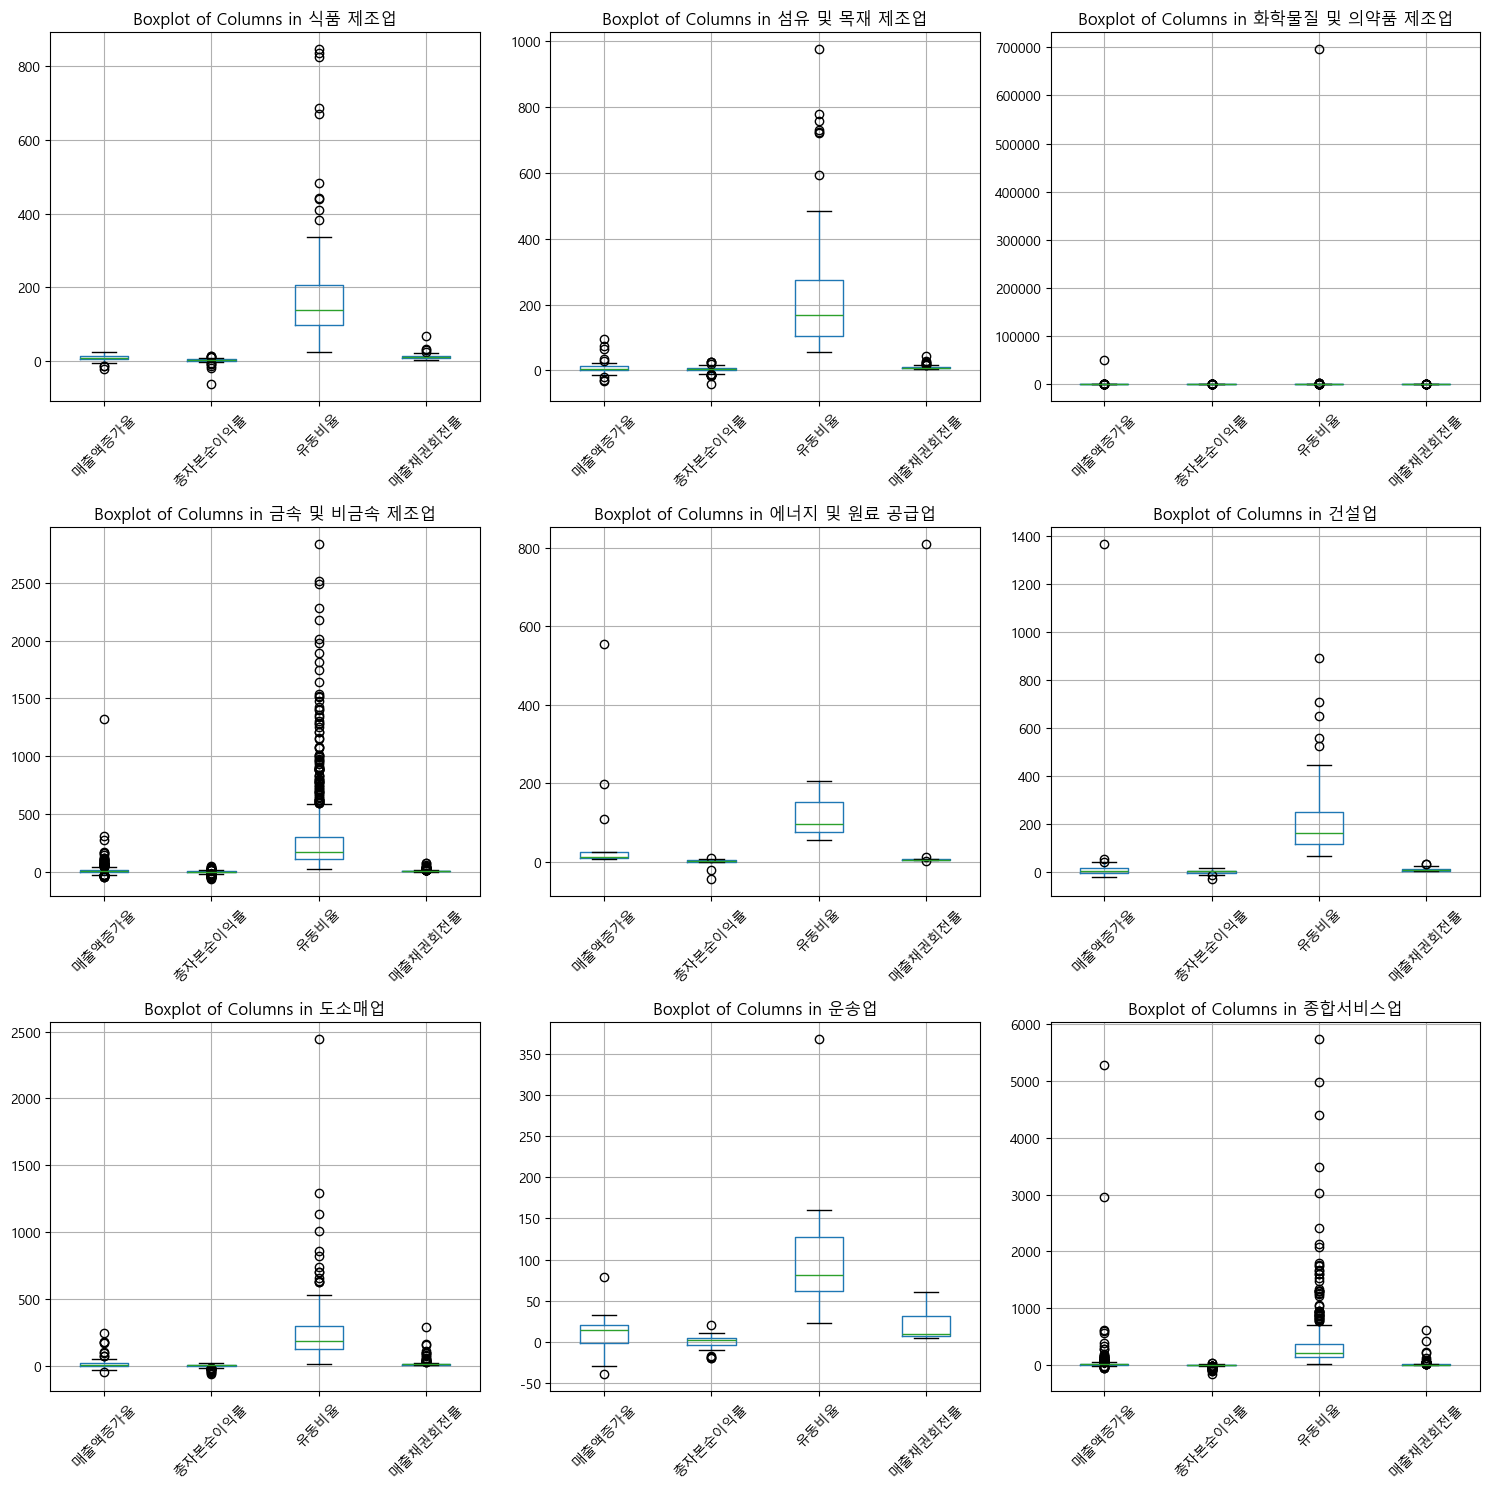

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, df_category in enumerate(dfs_by_category[:9]):
    row = i // 3
    col = i % 3
    df_category[['매출액증가율', '총자본순이익률', '유동비율', '매출채권회전률']].boxplot(ax=axes[row, col]) 
    axes[row, col].set_title(f'Boxplot of Columns in {dfs_by_category[i].values[0][14]}', fontsize=12)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()

In [ ]:
median_grade_by_column.items()

dict_items([('매출액증가율', (10.119999999999994, array([ 1.06933333,  7.67866667, 13.87866667, 23.87466667]))), ('순이익증가율', (0.8616666666666671, array([ 0.        ,  0.        , 10.608     , 38.63133333]))), ('총자본증가율', (11.448333333333334, array([ 1.80866667,  8.24066667, 16.63533333, 32.91133333]))), ('자기자본순이익률', (5.515, array([-11.21666667,   3.168     ,   8.064     ,  14.05666667]))), ('총자본순이익률', (3.0599999999999996, array([-7.226     ,  1.46133333,  4.47266667,  8.18933333]))), ('매출액순이익률', (3.7366666666666664, array([-18.21066667,   1.892     ,   5.96533333,  12.78466667]))), ('부채비율', (61.651666666666664, array([ 28.00266667,  48.53266667,  76.662     , 124.74333333]))), ('유동비율', (211.62, array([123.62666667, 175.68      , 261.71333333, 432.856     ]))), ('이자보상배율', (6.966666666666667, array([-4.61866667,  3.35466667, 14.87066667, 66.518     ]))), ('총자본회전률', (0.595, array([0.29133333, 0.5       , 0.71533333, 1.02866667]))), ('재고자산회전률', (14.741666666666665, array([  0.        ,   8.3846666

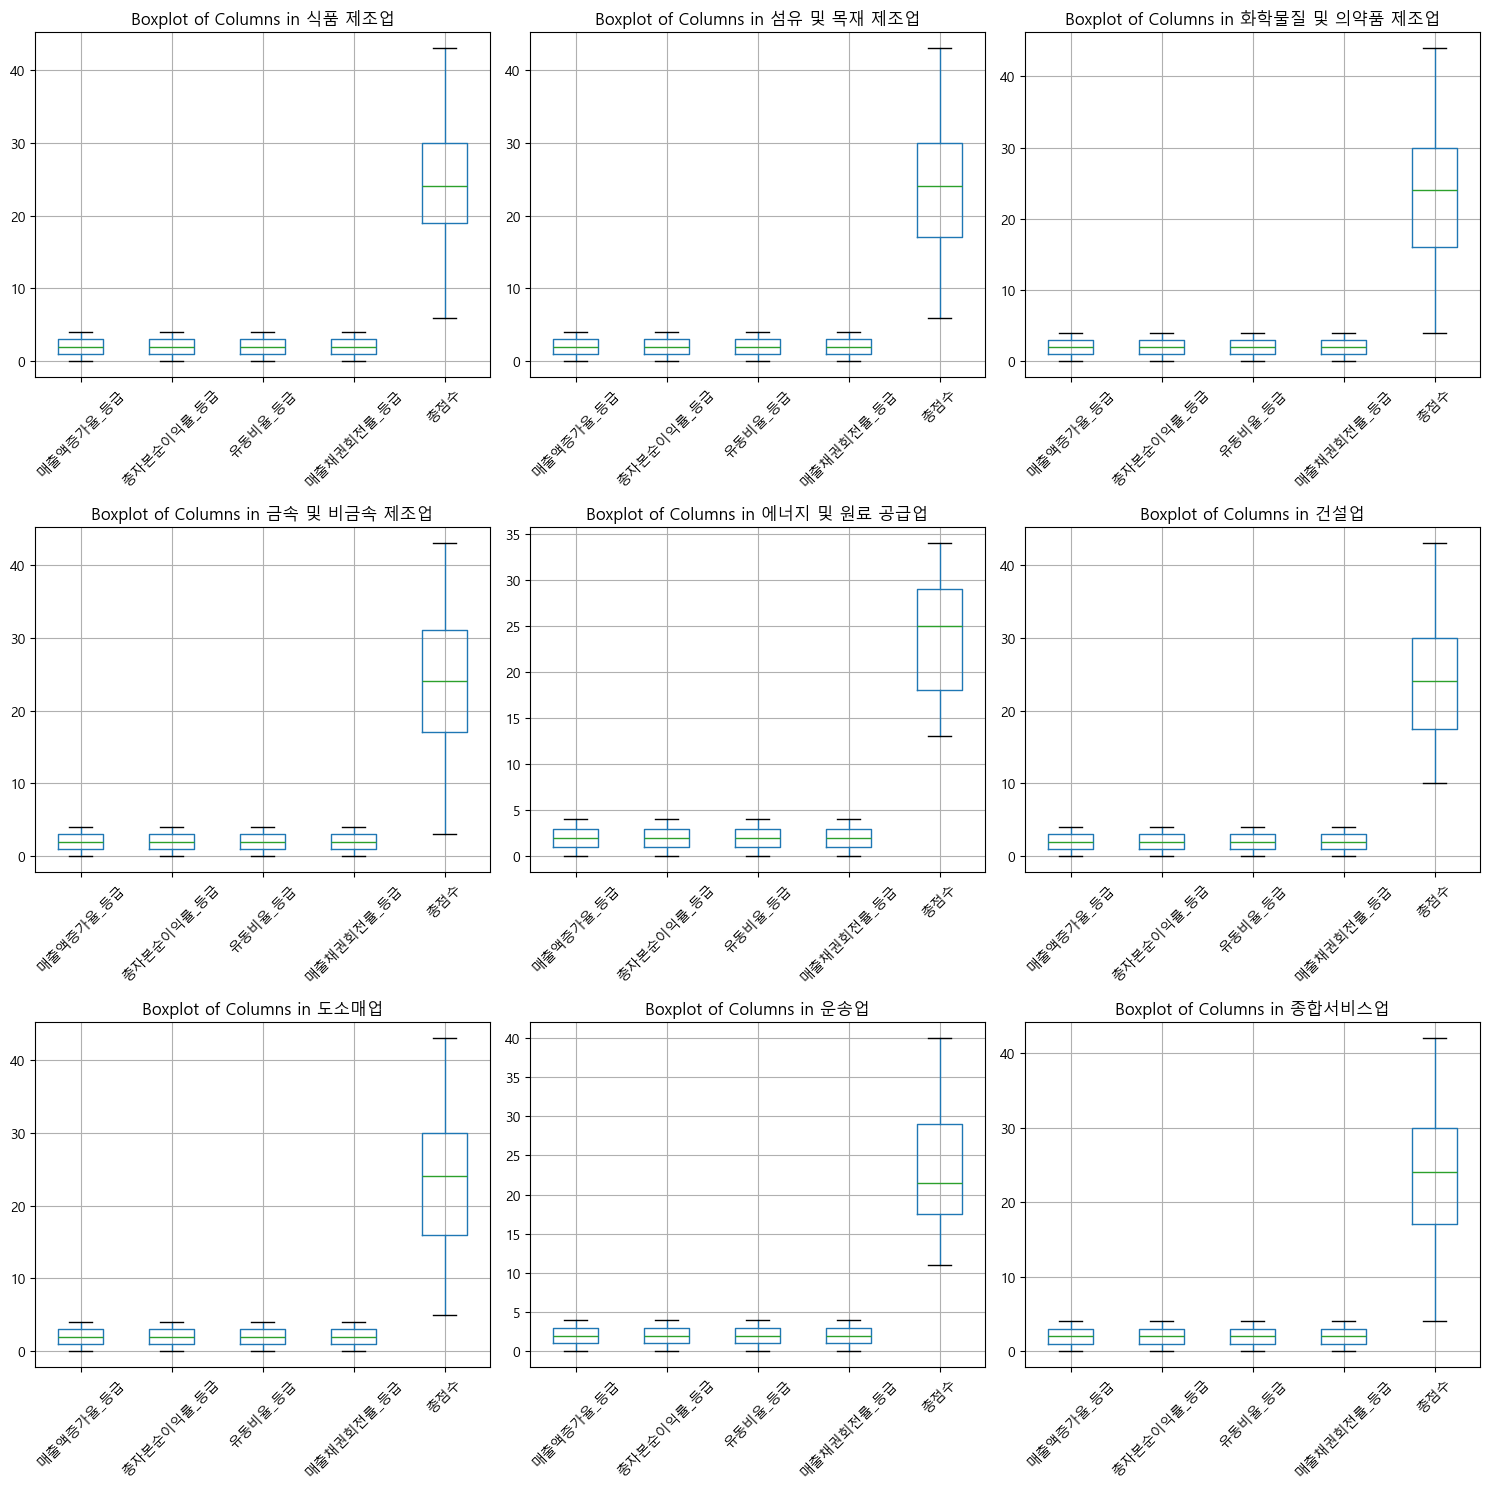

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, df_category in enumerate(dfs_by_category[:9]):
    row = i // 3
    col = i % 3
    df_category[['매출액증가율_등급', '총자본순이익률_등급', '유동비율_등급', '매출채권회전률_등급', '총점수']].boxplot(ax=axes[row, col])
    #axes[row, col].set_title(f'Boxplot of Columns in {df_category.columns.name}', fontsize=12)   
    axes[row, col].set_title(f'Boxplot of Columns in {dfs_by_category[i].values[0][14]}', fontsize=12)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()


* thresholds = np.percentile(column_data, [20, 40, 60, 80])
* 현재 컬럼의 데이터에 대한 20%, 40%, 60%, 80% 백분위수를 계산하여 등급을 분류하기 위한 임계값을 생성합니다. 이 임계값은 데이터를 분위수에 따라 5개의 등급으로 분류할 때 사용됩니다.
* {'매출액증가율': (10.119999999999994, array([ 1.06933333,  7.67866667, 13.87866667, 23.87466667])), ... }
  -- 10.119999999999994  : median() 중위값
  -- array([ 1.06933333,  7.67866667, 13.87866667, 23.87466667]   : thresholds = np.percentile(column_data, [20, 40, 60, 80]
  -- 매출액증가율 컬럼의 데이터를 하나씩 읽어서 thresholds 4개와 비교해서 1.06933333 보다 작으면 0, 1.0693333와  7.67866667 사이면 1, ... 23.874666 이상이면 4

In [ ]:
median_grade_by_column

{'매출액증가율': (10.119999999999994,
  array([ 1.06933333,  7.67866667, 13.87866667, 23.87466667])),
 '순이익증가율': (0.8616666666666671,
  array([ 0.        ,  0.        , 10.608     , 38.63133333])),
 '총자본증가율': (11.448333333333334,
  array([ 1.80866667,  8.24066667, 16.63533333, 32.91133333])),
 '자기자본순이익률': (5.515,
  array([-11.21666667,   3.168     ,   8.064     ,  14.05666667])),
 '총자본순이익률': (3.0599999999999996,
  array([-7.226     ,  1.46133333,  4.47266667,  8.18933333])),
 '매출액순이익률': (3.7366666666666664,
  array([-18.21066667,   1.892     ,   5.96533333,  12.78466667])),
 '부채비율': (61.651666666666664,
  array([ 28.00266667,  48.53266667,  76.662     , 124.74333333])),
 '유동비율': (211.62,
  array([123.62666667, 175.68      , 261.71333333, 432.856     ])),
 '이자보상배율': (6.966666666666667,
  array([-4.61866667,  3.35466667, 14.87066667, 66.518     ])),
 '총자본회전률': (0.595, array([0.29133333, 0.5       , 0.71533333, 1.02866667])),
 '재고자산회전률': (14.741666666666665,
  array([  0.        ,   8.38466667,

In [ ]:
dfs_by_category[8]['유동비율_등급'].value_counts()

유동비율_등급
0.0    89
4.0    89
3.0    88
1.0    88
2.0    88
Name: count, dtype: int64

In [ ]:
dfs_by_category[0].sort_values('총점수', ascending=False)

,회사명,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
163,뉴트리,20.786667,9.270000,25.270000,19.676667,13.570000,6.880000,49.083333,336.636667,46.876667,...,4.0,4.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,43.0
571,삼양식품,19.963333,12.766667,25.490000,18.586667,10.486667,9.376667,84.626667,144.080000,101.726667,...,4.0,4.0,4.0,2.0,2.0,4.0,3.0,4.0,3.0,41.0
1035,에이치피오,11.526667,-10.723333,33.836667,17.293333,13.660000,10.440000,18.240000,409.306667,299.746667,...,4.0,4.0,4.0,0.0,4.0,4.0,3.0,4.0,4.0,39.0
1145,오뚜기,10.580000,47.886667,19.026667,11.120000,6.400000,5.916667,71.636667,134.980000,17.023333,...,4.0,4.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,37.0
651,선진,23.093333,65.526667,10.716667,13.583333,4.516667,3.340000,191.896667,91.376667,5.113333,...,4.0,3.0,2.0,4.0,1.0,2.0,4.0,3.0,3.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,남양유업,-2.100000,0.000000,-5.116667,-7.733333,-6.606667,-6.643333,17.856667,441.616667,-116.733333,...,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,9.0
631,서울식품공업,1.750000,0.000000,-2.293333,-9.373333,-3.410000,-4.486667,163.843333,66.746667,-0.623333,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,3.0,0.0,9.0
1963,한탑,3.830000,0.000000,3.563333,-21.156667,-7.816667,-13.103333,160.763333,53.596667,-1.500000,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,8.0
501,보해양조,6.150000,0.000000,-3.970000,-0.783333,-0.463333,-0.670000,83.363333,115.313333,0.563333,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,7.0


In [ ]:
dfs_by_category[8].describe()

,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,총자본회전률,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,4.420000e+02,442.000000,...,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,41.583582,48.474600,21.476018,-3.622247,-1.832572,-156.598846,115.078401,372.714510,6.787399e+06,0.700950,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.997738,1.970588,2.000000,23.588235
std,293.286268,199.695893,33.098779,41.470875,19.236888,1123.070364,251.513269,556.089893,6.509245e+07,0.513746,...,1.419016,1.419016,1.419016,1.419016,1.419016,1.419016,1.419813,1.449543,1.419016,8.096227
min,-59.770000,-94.543333,-70.000000,-463.213333,-166.036667,-19428.436667,3.316667,26.380000,-3.654560e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,2.740000,0.000000,3.348333,-5.447500,-3.503333,-7.086667,32.812500,134.457500,-1.363333e+00,0.364167,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000
50%,10.120000,0.861667,11.448333,5.515000,3.060000,3.736667,61.651667,211.620000,6.966667e+00,0.595000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,24.000000
75%,20.020833,29.260000,28.589167,12.105833,7.545000,11.034167,111.545000,376.472500,4.158250e+01,0.935833,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,30.000000
max,5286.053333,2158.993333,224.103333,88.016667,40.473333,210.146667,3741.400000,5741.023333,1.000000e+09,4.556667,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,42.000000


In [ ]:
dfs_by_category[0].describe()

,매출액증가율,순이익증가율,총자본증가율,자기자본순이익률,총자본순이익률,매출액순이익률,부채비율,유동비율,이자보상배율,총자본회전률,...,자기자본순이익률_등급,총자본순이익률_등급,매출액순이익률_등급,부채비율_등급,유동비율_등급,이자보상배율_등급,총자본회전률_등급,재고자산회전률_등급,매출채권회전률_등급,총점수
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.00000,69.000000
mean,8.360821,17.515314,9.832947,-0.658551,1.522995,1.416908,118.599082,202.391884,142.938841,1.021401,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,24.000000
std,8.808594,93.500447,12.285583,34.797318,9.643123,12.416784,103.323461,188.710506,879.155634,0.434447,...,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,1.43486,8.239075
min,-21.706667,-113.536667,-5.116667,-269.686667,-64.026667,-64.870000,8.593333,23.650000,-116.733333,0.223333,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.000000
25%,4.710000,-14.696667,1.146667,1.336667,0.930000,0.830000,46.986667,98.013333,2.043333,0.720000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,19.000000
50%,7.686667,0.000000,6.520000,5.423333,2.610000,3.073333,86.283333,138.890000,5.113333,0.993333,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,24.000000
75%,13.453333,17.216667,13.900000,9.726667,4.723333,5.916667,153.316667,207.116667,14.610000,1.283333,...,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,30.000000
max,24.893333,675.626667,68.446667,19.676667,13.660000,20.723333,461.546667,847.230000,7252.180000,2.143333,...,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,43.000000
